In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
import numpy as np
import imodels
from imodels.util.data_util import get_clean_dataset
from tqdm import tqdm

sys.path.append('..')
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# change working directory to project root
while os.getcwd().split('/')[-1] != 'imodels-experiments':
    os.chdir('..')


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
X, y, feature_names = get_clean_dataset('fico', 'imodels')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
print('shape', X.shape, X_train.shape, y.mean())

shape (10459, 23) (7844, 23) 0.5219428243617936


In [6]:
accs = []
num_trees = []
num_rules_list = list(range(1, 20, 2))
num_rules_list = [5, 8, 29]
for num_rules in tqdm(num_rules_list):
    m = imodels.FIGSClassifier(max_rules=num_rules)
    m.fit(X_train, y_train, feature_names=feature_names)
    acc = np.mean(m.predict(X_test) == y_test)
    accs.append(acc)
    num_trees.append(len(m.trees_))
    print(accs)

 33%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 1/3 [00:00<00:00,  2.05it/s]

[0.718546845124283]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 2/3 [00:01<00:00,  1.27it/s]

[0.718546845124283, 0.7181644359464627]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.71s/it]

[0.718546845124283, 0.7181644359464627, 0.7139579349904398]


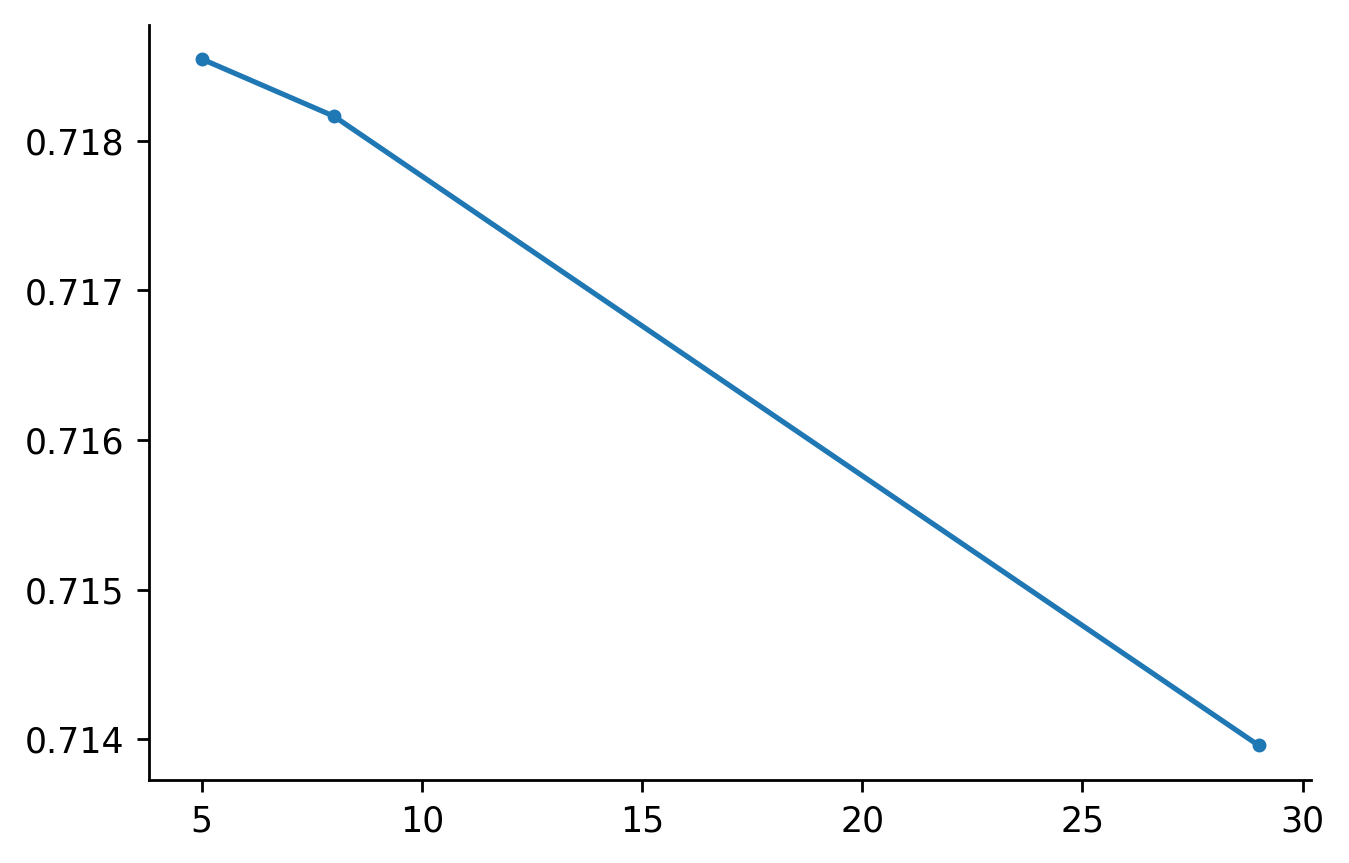

In [7]:
plt.plot(num_rules_list, accs, '.-')

# view an individual model

In [11]:
m = imodels.FIGSClassifier(max_rules=5)

In [18]:
sample_weight = np.ones_like(y_train)
# sample_weight[y_train == 1] = 100
m.fit(X_train, y_train, feature_names=feature_names, sample_weight=sample_weight)

FIGSClassifier(max_rules=5)

In [13]:
print(m)

------------
ExternalRiskEstimate <= 74.500 (Tree #0 root)
	ExternalRiskEstimate <= 67.500 (split)
		Val: 0.743 (leaf)
		Val: 0.561 (leaf)
	Val: 0.269 (leaf)

	+
MSinceMostRecentInqexcl7days <= -7.500 (Tree #1 root)
	Val: -0.196 (leaf)
	MSinceMostRecentInqexcl7days <= 0.500 (split)
		Val: 0.075 (leaf)
		Val: -0.096 (leaf)

	+
NumSatisfactoryTrades <= 26.500 (Tree #2 root)
	Val: 0.032 (leaf)
	Val: -0.090 (leaf)



In [14]:
def all_stats_curve(y_test, preds_proba, plot=False, thresholds=None):
    '''preds_proba should be 1d
    '''
    if thresholds is None:
        thresholds = sorted(np.unique(preds_proba))
    all_stats = {
        s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'f1']
    }
    for threshold in tqdm(thresholds):
        preds = preds_proba > threshold
        #         stats = sklearn.metrics.classification_report(y_test, preds,
        #                                                       output_dict=True,
        #                                                       zero_division=0)

        #         all_stats['sensitivity'].append(stats['1']['recall'])
        #         all_stats['specificity'].append(stats['0']['recall'])
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sens = tp / (tp + fn)
            spec = tn / (tn + fp)
            all_stats['sens'].append(sens)
            all_stats['spec'].append(spec)
            all_stats['ppv'].append(tp / (tp + fp))
            all_stats['npv'].append(tn / (tn + fn))
            all_stats['lr+'].append(sens / (1 - spec))
            all_stats['lr-'].append((1 - sens) / spec)
            all_stats['f1'].append(tp / (tp + 0.5 * (fp + fn)))

    if plot:
        plt.plot(all_stats['sens'], all_stats['spec'], '.-')
        plt.xlabel('sensitivity')
        plt.ylabel('specificity')
        plt.grid()
    return all_stats, thresholds


preds = m.predict_proba(X_test)[:, 1]
# print(sklearn.metrics.classification_report(y_test, preds))

In [ ]:
stats_curve = all_stats_curve(y_test, preds, plot=True)